# Consigna 

- Se cuenta con un archivo que indica en cada fila si dos usuarios son amigos entre sí y con un archivo que para cada usuario indica si tiene un atributo o no (no está muy clara la info de qué son esos atributos).
- Queremos poder construir grafos a partir de esos atributos, por ejemplo si dos personas tienen muchos atributos en común deberían estar conectadas.
- Luego queremos comparar los grafos reales con los hechos por atributos y ver como podemos optimizar algunos parámetros para que esos gráfos se parezcan. 
- La idea es usar PCA en un momento para procesar los atributos, para esto pueden utilizar python.
- La consigna es la misma con y sin PCA, pensalo como qué tenés que repeterir la búsqueda de umbral para sinPCA, PCAk=1, PCAk=2, etc, con k variando en un rango interesante, tipo k=1:10, y luego saltos exponenciales quizás
-  Se busca medir la correlación entre los valores en A y los valores de una nueva matriz de adyacencia obtenida a partir de los atributos F pasados por PCA. 

Por ejemplo, el siguiente gráfico muestra el valor de la correlación para distintos umbrales utilizados para calcular la nueva matriz de adyacencia, y también distintas cantidad de componentes principales 

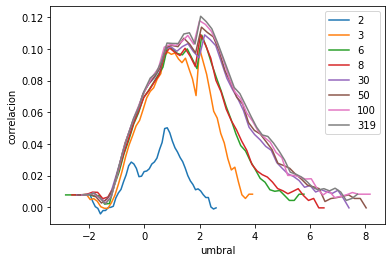

# Resolucion 

## Importaciones y Definiciones 

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt

In [2]:
!wget https://snap.stanford.edu/data/facebook.tar.gz
!tar xf facebook.tar.gz

--2023-10-17 15:58:50--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.1’

facebook.tar.gz.1   100%[===================>] 714,95K   166KB/s    in 4,3s    

2023-10-17 15:58:55 (166 KB/s) - ‘facebook.tar.gz.1’ saved [732104/732104]



In [3]:
# Red de Amistad 786x786
G = nx.read_edgelist('facebook/1684.edges')
A = nx.to_numpy_array(G)

# Matriz de Atributos 786x319
F = np.loadtxt('facebook/1684.feat')
df = pd.DataFrame(F).set_index(0)
F = df.loc[list(map(int,G.nodes()))].values

In [ ]:
# Dibujar el grafo original
plt.figure(figsize=(12, 10))
nx.draw(G, with_labels=False, node_size=50, node_color='blue', edge_color='gray', alpha=0.6)
plt.title("Grafo original de datos de Facebook")
plt.show()

## 3.1

Con los datos de Facebook, computar la matriz de similaridad con producto interno
de la matriz de atributos, proponer un umbral u y construir un grafo conectando
los nodos que superan ese umbral.

In [24]:
def crear_grafo_desde_similaridad(M, u):
    matriz_similaridad = M.dot(M.T)
    num_nodos = matriz_similaridad.shape[0]
    grafo = nx.Graph()
    
    # Añadir nodos al grafo
    grafo.add_nodes_from(range(num_nodos))
    
    # Añadir aristas basadas en el umbral
    for i in range(num_nodos):
        for j in range(i + 1, num_nodos):  # Para evitar repetir pares y auto-conexiones
            if matriz_similaridad[i, j] > u:
                grafo.add_edge(i, j)
                
    # Garantizar que el grafo tenga el mismo número de nodos que la matriz de atributos
    for nodo in range(F.shape[0]):
        if nodo not in grafo:
            grafo.add_node(nodo)
                
    A_pca = nx.to_numpy_array(grafo)
    return grafo, A_pca

In [ ]:
umbral = 1
grafo_matriz_similaridad, matriz_adyacencia_similaridad = crear_grafo_desde_similaridad(F, umbral)

plt.figure(figsize=(10, 8))
nx.draw(grafo_matriz_similaridad, with_labels=False, node_size=50, node_color='blue', edge_color='gray', alpha=0.6)
plt.title("Grafo generado a partir de la matriz de similaridad con umbral = {}".format(umbral))
plt.show()

## 3.2 

Queremos comparar la red de amistades original y la construida a partir de los datos. Proponemos dos formas para compararlas:
1. Comparar las redes mediante la correlación de las matrices de adyacencia estiradas (flatten).
2. Comparar utilizando la correlación entre las listas de autovalores.

In [13]:
def correlacion_estirada_matrices_adyacencia(matriz1, matriz2):
    matriz1_aplanada = matriz1.flatten()
    matriz2_aplanada = matriz2.flatten()
    
    return np.corrcoef(matriz1_aplanada, matriz2_aplanada)[0, 1]

correlacion_estirada = correlacion_estirada_matrices_adyacencia(A, matriz_adyacencia_similaridad)
correlacion_estirada

0.023245642800196913

In [14]:
def correlacion_autovalores_matrices_adyacencia(matriz1, matriz2):
    eigenvalues1, _ = eigh(matriz1)
    eigenvalues2, _ = eigh(matriz2)

    return np.corrcoef(eigenvalues1, eigenvalues2)[0, 1]

correlacion_autovalores = correlacion_autovalores_matrices_adyacencia(A, matriz_adyacencia_similaridad)
correlacion_autovalores

0.6085568857436752

## 3.3 

Realizar el procedimiento anterior para suficientes valores de umbral y buscar el
valor optimo que genera la red de atributos mas similar al grafo de amistades. 

In [15]:
umbrales = np.arange(0, 8.1, 0.25)
correlaciones_estirada = []
correlaciones_autovalores = []

for u in umbrales:
    _, matriz_adyacencia_sim = crear_grafo_desde_similaridad(F, u)
     
    correlacion_estirada = correlacion_estirada_matrices_adyacencia(A, matriz_adyacencia_sim)
    correlaciones_estirada.append(correlacion_estirada)
    
    correlacion_autovalores = correlacion_autovalores_matrices_adyacencia(A, matriz_adyacencia_sim)
    correlaciones_autovalores.append(correlacion_autovalores)

umbral_optimo_matrices = umbrales[np.argmax(correlaciones_estirada)]
correlacion_maxima_matrices = max(correlaciones_estirada)

umbral_optimo_autovalores = umbrales[np.argmax(correlaciones_autovalores)]
correlacion_maxima_autovalores = max(correlaciones_autovalores)

umbral_optimo_matrices, correlacion_maxima_matrices, umbral_optimo_autovalores, correlacion_maxima_autovalores


(5.0, 0.10962949720569079, 6.0, 0.9506214905358324)

## 3.4 

Filtrar la matriz de atributos utilizando PCA: Computar la matriz de covarianza,
luego los autovectores. Seleccionar k componentes principales y proyectar los datos
al nuevo espacio. Repetir el punto anterior para varios valores de k y varios valores
de u. Analizar los resultados.

In [16]:
def PCA(M, k):
    # Centrar la matriz
    M_centralizada = M - np.mean(M, axis=0)
    
    # Calcular la matriz de covarianza
    cov_matrix = np.cov(M_centralizada, rowvar=False)
    
    # Encontrar autovectores y autovalores
    autovalores, autovectores = eigh(cov_matrix)
    
    # Ordenar autovectores por autovalores en orden decreciente
    indices_ordenados = np.argsort(autovalores)[::-1]
    autovectores_ordenados = autovectores[:, indices_ordenados]
    
    # Seleccionar los primeros k autovectores para la matriz de transformación
    matriz_transformacion = autovectores_ordenados[:, :k]
    
    # Proyectar la matriz original usando la matriz de transformación
    M_proyectado = np.dot(M_centralizada, matriz_transformacion)
    
    return M_proyectado

In [20]:
def analisis_con_PCA(matriz_amistad, matriz_atributos, rangos_k, rangos_u):
    resultados = []
    
    for k in rangos_k:
        matriz_atributos_pca = PCA(matriz_atributos, k)
        
        for u in rangos_u:
            grafo_pca, matriz_similaridad_pca = crear_grafo_desde_similaridad(matriz_atributos_pca, u)
            correlacion_estirada = correlacion_estirada_matrices_adyacencia(matriz_amistad, matriz_similaridad_pca)
            correlacion_autovalores = correlacion_autovalores_matrices_adyacencia(matriz_amistad, matriz_similaridad_pca)
            
            resultados.append({
                'k': k,
                'u': u,
                'correlacion_matrices': correlacion_estirada,
                'correlacion_autovalores': correlacion_autovalores
            })

    return resultados

rangos_k_pca = [list(range(1, 11)) + [20, 50, 100, 150, 200, 250, 300] ]
rangos_u_pca = np.arange(0, 8.1, 0.25)

In [21]:
def plotear_resultados(resultados, rangos_k):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    for k in rangos_k:
        resultados_k = [res for res in resultados if res['k'] == k]
        umbrales = [res['u'] for res in resultados_k]
        correlaciones = [res['correlacion_matrices'] for res in resultados_k]
        
        plt.plot(umbrales, correlaciones, label=f'k = {k}')
        
    plt.title('Correlación de Matrices Estiradas vs Umbral (u)')
    plt.xlabel('Umbral (u)')
    plt.ylabel('Correlación')
    plt.legend()

    plt.subplot(1, 2, 2)
    for k in rangos_k:
        resultados_k = [res for res in resultados if res['k'] == k]
        umbrales = [res['u'] for res in resultados_k]
        correlaciones = [res['correlacion_autovalores'] for res in resultados_k]
        
        plt.plot(umbrales, correlaciones, label=f'k = {k}')
        
    plt.title('Correlación de Autovalores vs Umbral (u)')
    plt.xlabel('Umbral (u)')
    plt.ylabel('Correlación')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

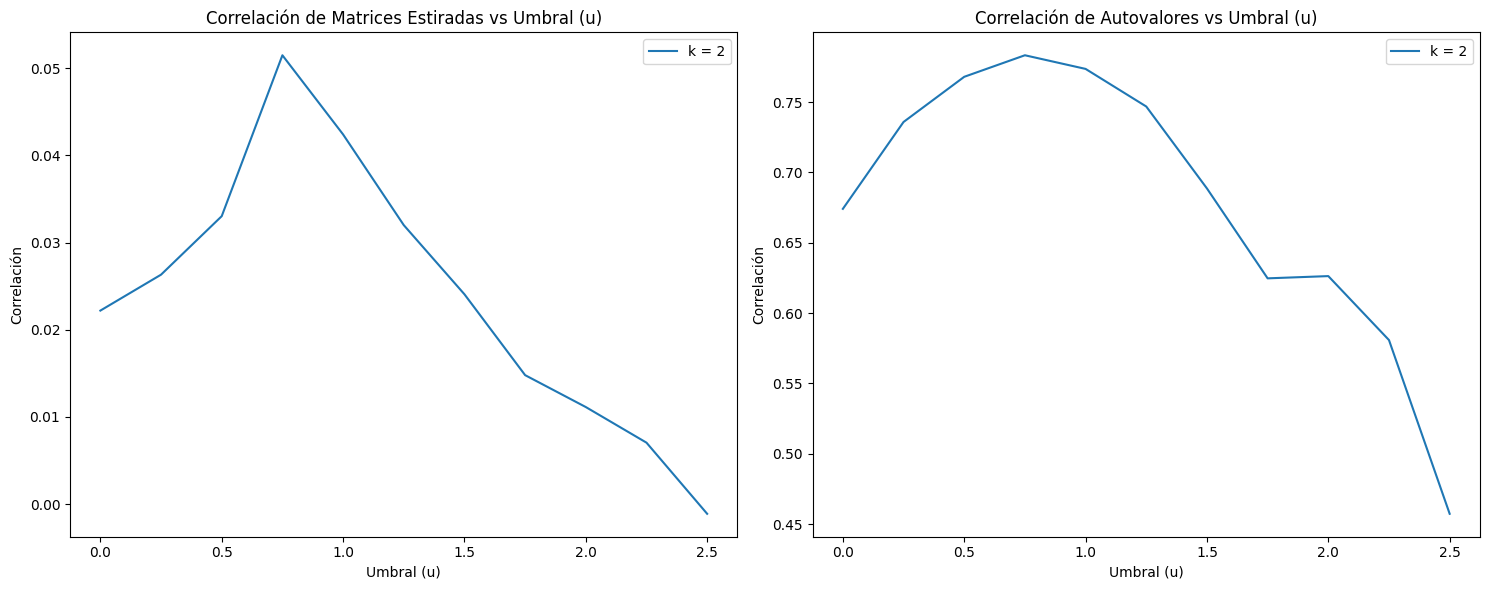

In [22]:
resultados_pca = analisis_con_PCA(A, F, rangos_k_pca, rangos_u_pca)
plotear_resultados(resultados_pca, rangos_k_pca)